# PyGEM Advanced Test - Dynamical Spinup

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
Created: 04OCT2025<br> <br>
Objective: build on the [*advanced_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test.ipynb) demonstration and goes over running inversion and dynamical spinup, followed by calibration and simulation. If you have yet to do so, we suggest going through the advanced test notebook in full before proceeding.<br>

This demonstration utilizes PyGEM's *sample_data* for Khumbu Glacier (RGI60-15.03733), which should have been downloaded during model installation and setup (see [here](https://pygem.readthedocs.io/en/latest/install_pygem.html)), but can also be downloaded directly [here](https://drive.google.com/file/d/1Wu4ZqpOKxnc4EYhcRHQbwGq95FoOxMfZ/view?usp=drive_link).<br>

Tasks:
1. Run inversion
2. Run dynamical spinup
3. Run calibration
4. Run simulations

> **📝 Note:**<br>
> In this notebook, any PyGEM Python scripts that are called will be preceeded by ```!```. In Jupyter Notebook, the ```!``` character is used to execute shell commands directly from a notebook cell. When you prefix a command with ```!```, Jupyter sends it to the system's command-line shell for execution, instead of interpreting it as Python code. Command-line arguments are also bracketed (e.g., ```{arg}```), when passing Python variables to a command-line shell from within a Jupyter Notebook. If executing a given PyGEM script directly from one's terminal, remove the ```!``` character and brackets ```{}``` around arguments.
>

> **⚠️ Warning:**<br>
> Ensure that the `root` parameter in PyGEM configuration file points to the correct path for the sample dataset (should end in */sample_data/*, not */sample_data_tw/*):<br>

In [1]:
%%bash
grep 'root:' ~/PyGEM/config.yaml

root: /Users/btober/PyGEM/sample_data/sample_data # note, this parameter must be modfied as to point to the appropriate location. all other paths are assumed relative to this (inputs and outputs).


If the incorrect path is set, you may manually modify with the text editor of your choice so that the `root` parameter is set to point to wherever the appropriate sample dataset is located on your computer.<br>

In [2]:
### imports ###
import os, sys, glob, json
from oggm import cfg, tasks, workflow
from IPython.display import Image, display
# pygem imports
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.
# get root path
rootpath = pygem_prms["root"]
# reduce oggm logging level to keep notebook clean
config_manager.update_config(updates={'oggm.logging_level' : 'CRITICAL'})

## 1. Ice thickness inversion

In order to run dynamical spinup, we will need the output from first running ice thickness inversion. This would typically be performed using a regionally-calibrated Glen's A ice creep calue. See [*run_inversion.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_inversion.ipynb) for more information. Here we'll run inversion for a single glacier of interest using previously calibrated regional Glen's A values.<br><br>
What are the options of PyGEM's *run_inversion* script?

In [3]:
!run_inversion -h

2025-10-15 17:36:55: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-10-15 17:36:55: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-10-15 17:36:55: oggm.cfg: Multiprocessing: using all available processors (N=10)
usage: run_inversion [-h] [-rgi_region01 RGI_REGION01 [RGI_REGION01 ...]]
                     [-rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]]
                     [-rgi_glac_number_fn RGI_GLAC_NUMBER_FN]
                     [-calibrate_regional_glen_a CALIBRATE_REGIONAL_GLEN_A]
                     [-ncores NCORES] [-reset_gdirs] [-v]

Perform glacier bed inversion (defaults to find best Glen's A for each RGI
order 01 region)

options:
  -h, --help            show this help message and exit
  -rgi_region01 RGI_REGION01 [RGI_REGION01 ...]
                        Randoph Glacier Inventory region (can take multiple,
                        e.g. `-run_region01 1 2 3`)
  -rgi_glac_number RGI_GLAC_NUMB

We'll run inversion with the following arguments:
<pre>
glac_no =                       15.03733
calibrate_regional_glen_a =     False
</pre>

We first need to set `setup.rgi_region01=None` in our confiuration file (or comment out any list items following `setup.rgi_region01`).

In [4]:
# update the rgi_region01 key as described above
config_manager.update_config(updates={'setup.rgi_region01' : None})

In [5]:
glac_no = 15.03733
!run_inversion -rgi_glac_number {glac_no} -calibrate_regional_glen_a False

2025-10-15 17:36:57: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-10-15 17:36:57: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-10-15 17:36:57: oggm.cfg: Multiprocessing: using all available processors (N=10)
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]
2025-10-15 17:36:57: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers
2025-10-15 17:36:57: oggm.workflow: Execute entity tasks [process_climate_data] on 1 glaciers
2025-10-15 17:36:57: oggm.core.climate: (RGI60-15.03733) process_climate_data
2025-10-15 17:36:57: oggm.shop.w5e5: (RGI60-15.03733) process_gswp3_w5e5_data
2025-10-15 17:36:57: oggm.workflow: Execute entity tasks [mb_df_to_gdir] on 1 glaciers
2025-10-15 17:36:57: pygem.shop.mbdata: (RGI60-15.03733) mb_df_to_gdir
2025-10-15 17:36:57: oggm.workflow: Execute entity tasks [debris_to_gdir] on 1 glaciers
2025-10-15 1

## 2. Dynamical spinup

We'll now run dynamical spinup, seeking to match the glacier area given by the Randolph Glacier Inventory.<br><br>
What are the options of PyGEM's *run_spinup* script?

In [6]:
!run_spinup -h

usage: run_spinup [-h] [-rgi_region01 RGI_REGION01 [RGI_REGION01 ...]]
                  [-rgi_region02 RGI_REGION02 [RGI_REGION02 ...]]
                  [-rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]]
                  [-rgi_glac_number_fn RGI_GLAC_NUMBER_FN]
                  [-spinup_period SPINUP_PERIOD] [-target_yr TARGET_YR]
                  [-ye YE] [-ncores NCORES]
                  [-mb_model_params {regional_priors,emulator}]

perform dynamical spinup

options:
  -h, --help            show this help message and exit
  -rgi_region01 RGI_REGION01 [RGI_REGION01 ...]
                        Randoph Glacier Inventory region (can take multiple,
                        e.g. `-run_region01 1 2 3`)
  -rgi_region02 RGI_REGION02 [RGI_REGION02 ...]
                        Randoph Glacier Inventory subregion (either `all` or
                        multiple spaced integers, e.g. `-run_region02 1 2 3`)
  -rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]
                    

We'll run spinup with the following arguments:
<pre>
glac_no =           15.03733
mb_model_params =   emulator   
</pre>

In [7]:
!run_spinup -rgi_glac_number {glac_no} -mb_model_params emulator

Processing with 1 cores... 
[['15.03733']]
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]


If successful, the script will run without errors and the following datasets will be generated:

* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-15/RGI60-15.03/RGI60-15.03733/diagnostics.json*<br>
* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-15/RGI60-15.03/RGI60-15.03733/model_diagnostics_dynamic_spinup_pygem_mb.nc*<br>
* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-15/RGI60-15.03/RGI60-15.03733/model_geometry_dynamic_spinup_pygem_mb.nc*<br>
* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-15/RGI60-15.03/RGI60-15.03733/fl_diagnostics_dynamic_spinup_pygem_mb.nc*<br>

The key file PyGEM will use for next running calibration and simulations is *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-15/RGI60-15.03/RGI60-15.03733/model_geometry_dynamic_spinup_pygem_mb.nc*, which contains the model geometry for each year of dynamical spinup.

In [8]:
%%bash -s "$rootpath"
tree -I '.DS_Store' $1/oggm_gdirs/

/Users/btober/PyGEM/sample_data/sample_data/oggm_gdirs/
├── log
│ �� └── RGI60-15.03733.ERROR
└── per_glacier
    └── RGI60-15
        └── RGI60-15.03
            └── RGI60-15.03733
                ├── climate_historical.nc
                ├── debris_ed.tif
                ├── debris_hd.tif
                ├── dem.tif
                ├── dem_source.txt
                ├── diagnostics.json
                ├── downstream_line.pkl
                ├── elevation_band_flowline.csv
                ├── fl_diagnostics_dynamic_spinup_pygem_mb.nc
                ├── glacier_grid.json
                ├── gridded_data.nc
                ├── intersects.tar.gz
                ├── inversion_flowlines.pkl
                ├── inversion_input.pkl
                ├���─ inversion_output.pkl
                ├── log.txt
                ├��─ mb_calib.json
                ├── mb_calib_pygem.json
                ���── model_diagnostics_dynamic_spinup_pygem_mb.nc
                ├── model_flowlines.pkl
         

We can also check OGGM's log file for a successful spinup run:

In [9]:
%%bash -s "$rootpath"
tail -1 $1/oggm_gdirs/per_glacier/RGI60-15/RGI60-15.03/RGI60-15.03733/log.txt

2025-10-15T17:37:03;run_dynamic_spinup_dynamic_spinup_pygem_mb;time:0.8475520610809326;SUCCESS


## 3. Run calibration

We'll now run Bayesian inference model calibration using the model flowlines from dynamical spinup. We can achieve this with the `-spinup` flag.

The following parameters should either be set within your configuration file, or passed to the *run_calibration* script as command line arguments:
<pre>
glac_no =             15.03733
ref_startyear =       2000
ref_endyear =         2019
option_calibration =  MCMC
</pre>

In [10]:
# passing the above parameters as command line arguments:
glac_no = 15.03733
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -option_calibration MCMC -spinup -v  -p # `-v` == vervose (will generate some diagnostic plots) and `-p` == progress bar

Processing: ERA5
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]
ERA5 : RGI60-15.03733
  mb_data (mwea): -0.45 +/- 0.11
15.03733 chain 0 initials:	tbias: 0.78, kp: 0.91, ddfsnow: 0.0041
20010it [00:14, 1348.72it/s]                                                    
mb_mwea_mean: -0.426 mb_mwea_std: 0.104 
mb_obs_mean: -0.446 mb_obs_std: 0.106
Figure(600x800)
Figure(300x200)
Total processing time: 15.965710878372192 s


Open a couple diagnostic plots. These plots are simply intended to serve as diagnostics of the performance of Bayesian inference calibration.<br><br>

The first plot shows the accepted (orange) and proposed (blue) steps across the MCMC sampling chain for each of PyGEM's three model parameters (temperature bias, precipitation factor, and the degree-day factor of snow, respectively for the top three panels). The fourth panel down shows the modeled mass balance across the chain compared to geodetic observations (with 1- and 2$\sigma$ uncertainty shown by the shaded region). The final panel shows the acceptance rate across the chain (accepted v. proposed samples).<br><br>
For further analysis of MCMC calibration, see the [*analyze_mcmc.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/analyze_mcmc.ipynb) notebook.

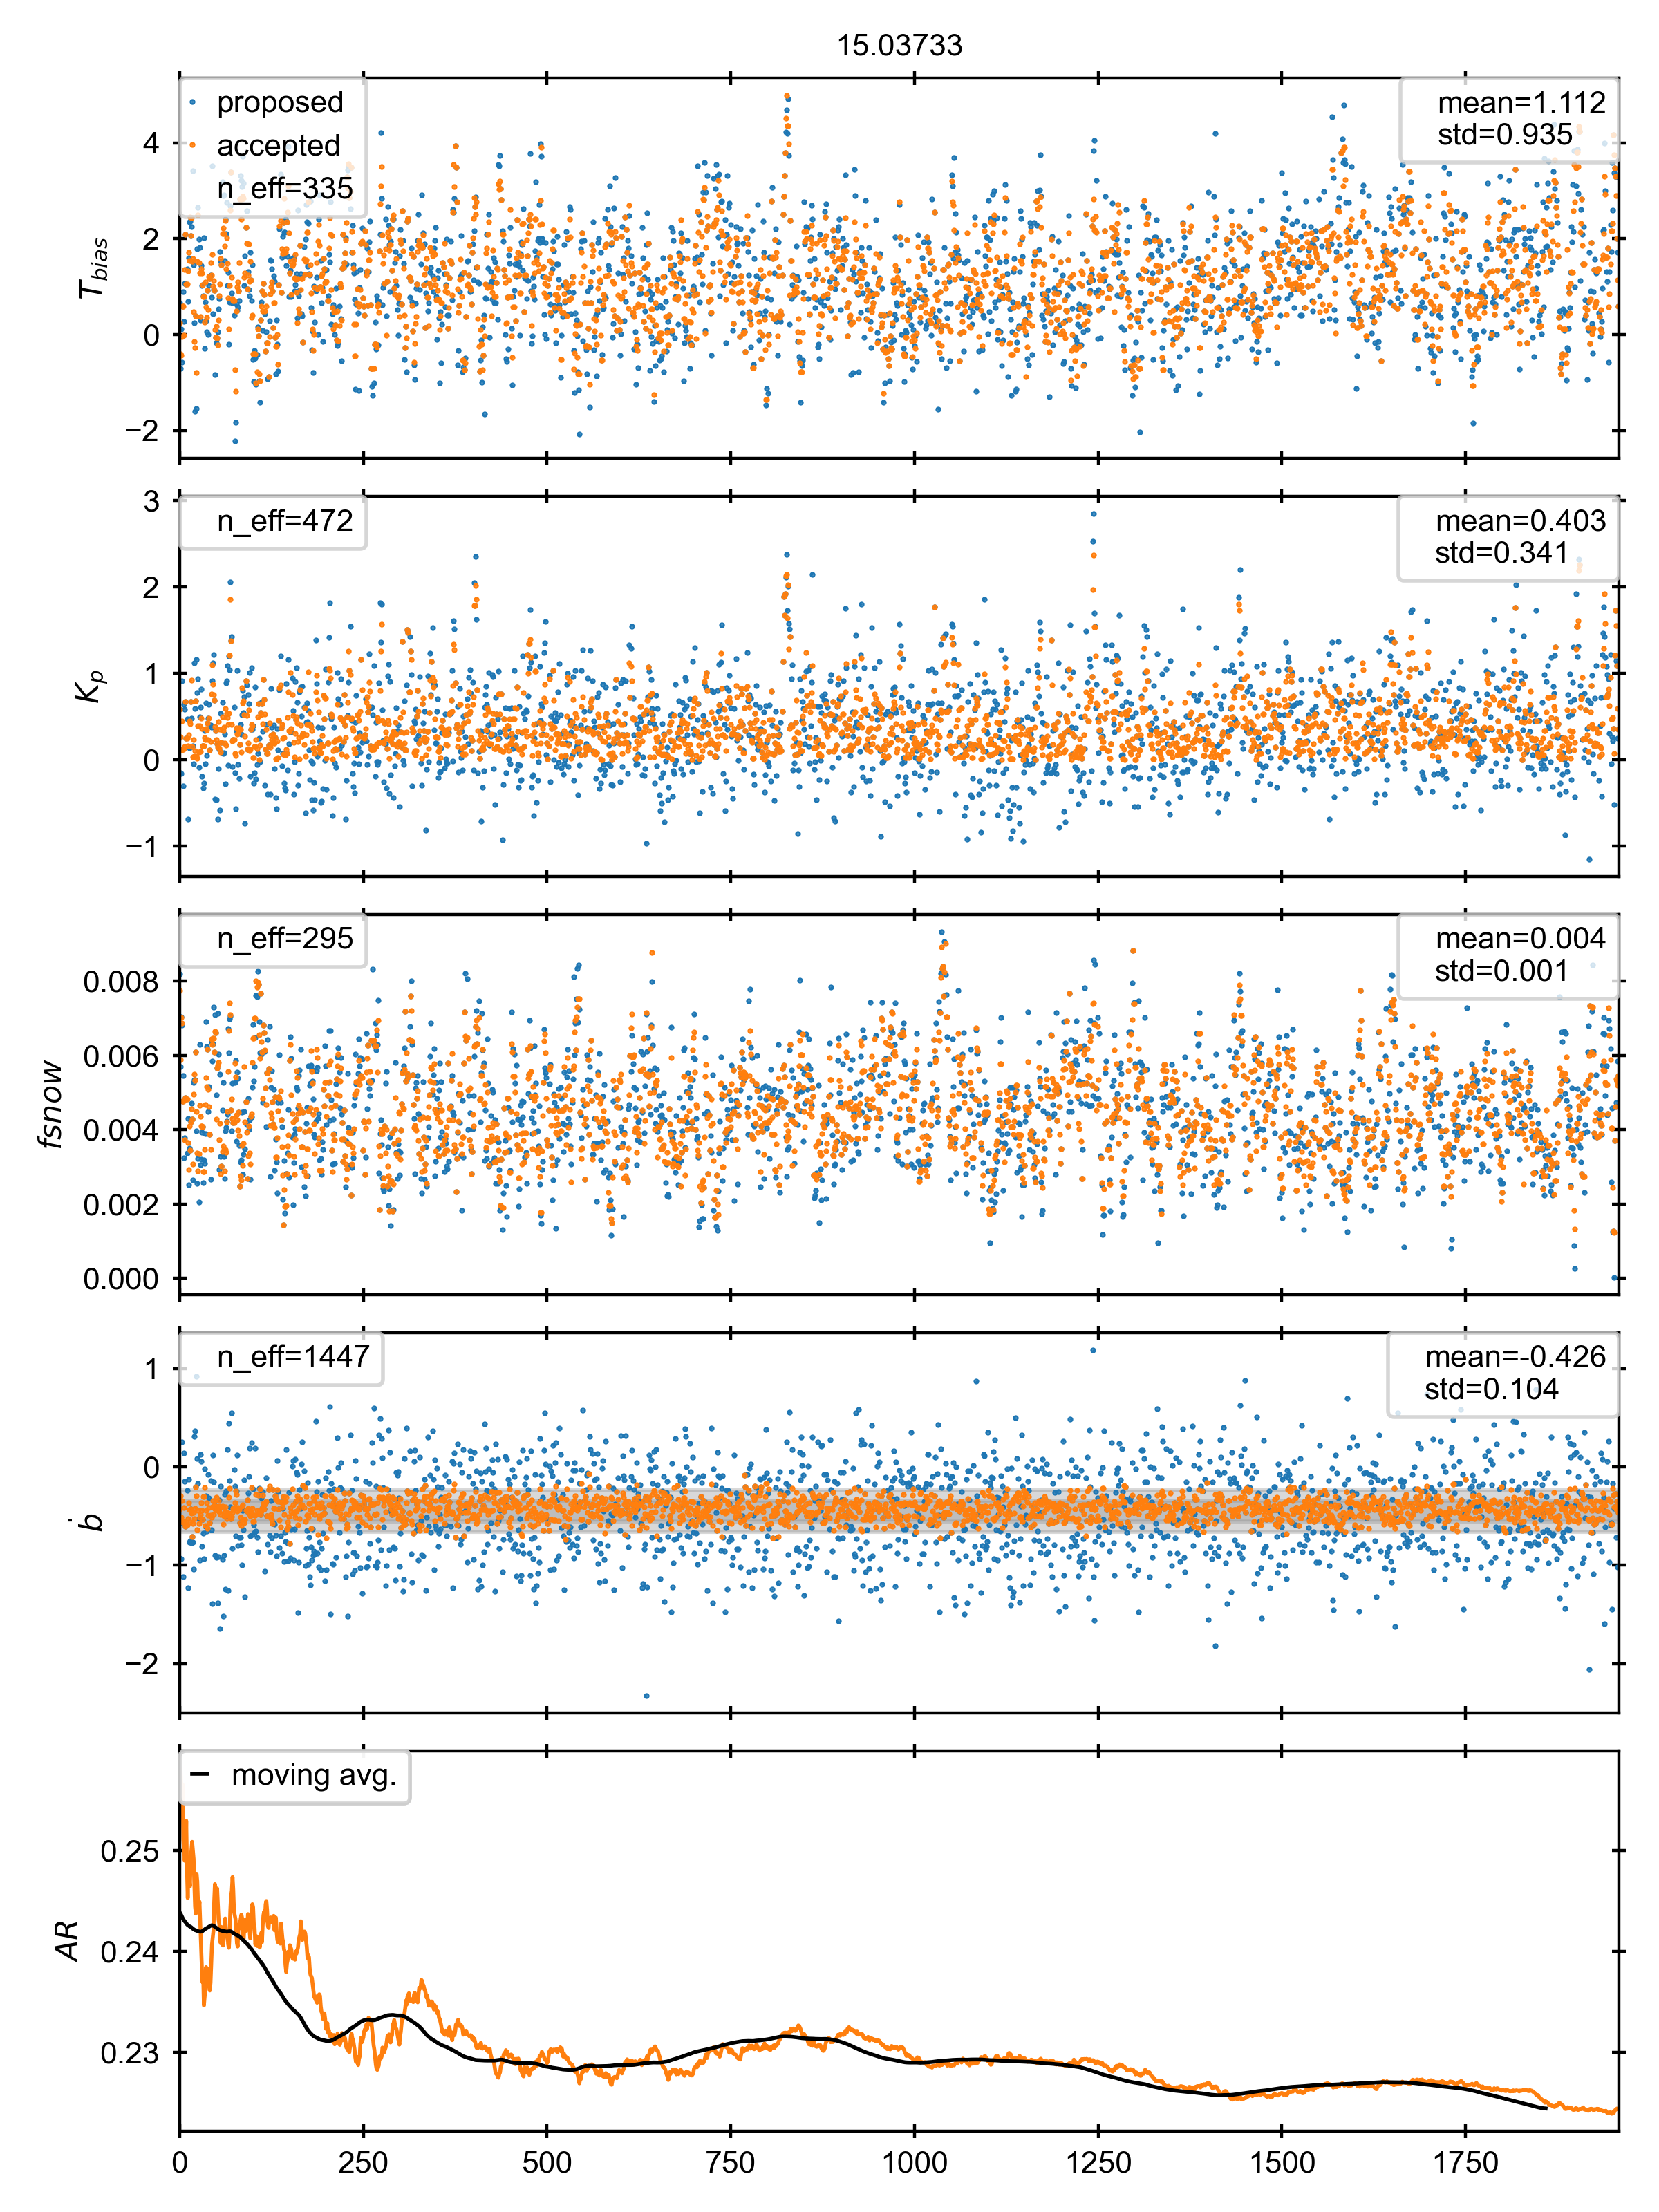

In [11]:
reg = str(glac_no).split('.')[0].zfill(2)
display(Image(filename=f'{rootpath}/Output/calibration/{reg}/fig/{glac_no}-chain0.png', width=500, height=300))

The next plot shows a histogram of the residual mass balance (modeled *minus* observed).

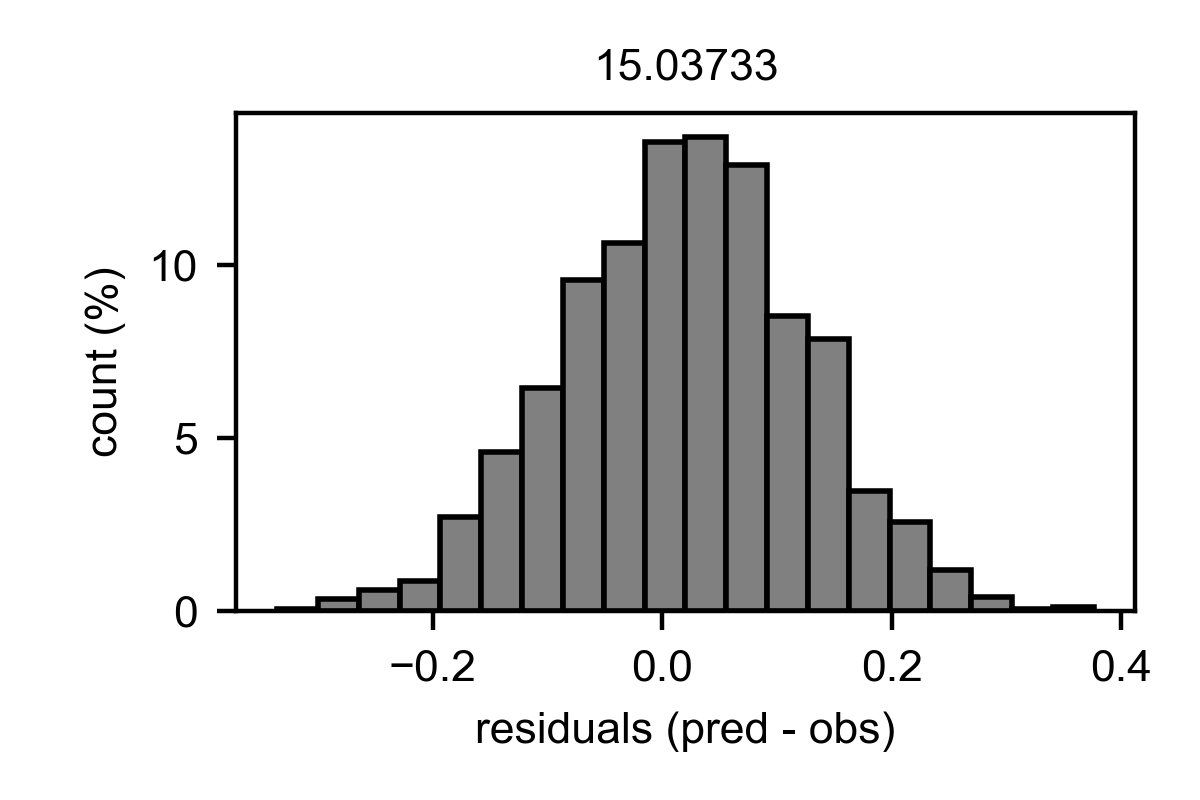

In [12]:
display(Image(filename=f'{rootpath}/Output/calibration/{reg}/fig/{glac_no}-chain0-residuals-0.png', width=300, height=300))

## 4. MCMC simulations

We'll now run future simulations using the model flowlines from dynamical spinup. The following parameters should either be set within your configuration file, or passed to the *run_simulation* script as command line arguments:
<pre>
glac_no =               15.03733
sim_climate_name =      CESM2
sim_climate_scenario =  ssp245
sim_startyear =         2000
sim_endyear =           2100
option_calibration =    MCMC
nsims =                 50
option_dynamics =       OGGM
use_reg_glena =         False         
</pre>


In [13]:
# passing the above parameters as command line arguments:
gcm_name = 'CESM2'
scenario = 'ssp245'
!run_simulation -rgi_glac_number {glac_no} -sim_climate_name {gcm_name} -sim_climate_scenario {scenario} -sim_startyear 2000 -sim_endyear 2100 -option_calibration MCMC -nsims 50 -option_dynamics OGGM -use_regional_glen_a False -spinup -outputfn_sfix spinup_

2025-10-15 17:37:24: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-10-15 17:37:24: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-10-15 17:37:24: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-10-15 17:37:24: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2025-10-15 17:37:24: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2025-10-15 17:37:24: oggm.cfg: PARAMS['trapezoid_lambdas'] changed from `2.0` to `1`.
Processing: CESM2 ssp245
Processing with 1 cores...
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]
CESM2 : RGI60-15.03733
Total processing time: 13.457624912261963 s


If successful, we should see the following simulation dataset:

In [14]:
%%bash -s "$rootpath" "$reg" "$gcm_name" "$scenario"
ls -lah $1/Output/simulations/$2/$3/$4/stats/*50sets*spinup*.nc

-rw-r--r--@ 1 btober  staff    99K Oct 15 17:37 /Users/btober/PyGEM/sample_data/sample_data/Output/simulations/15/CESM2/ssp245/stats/15.03733_CESM2_ssp245_MCMC_ba1_50sets_2000_2100_spinup_all.nc


## Plot

Visualize the model output. First use xarray to load the netcdf file shown above.

In [15]:
import xarray as xr
ds = xr.open_dataset(glob.glob(f'{rootpath}/Output/simulations/{reg}/{gcm_name}/{scenario}/stats/{glac_no}_{gcm_name}_{scenario}_MCMC_*50sets*_2000_2100_spinup_all.nc*')[0])
ds

<xarray.Dataset> Size: 56kB
Dimensions:                   (glac: 1, time: 1212, year: 102)
Coordinates:
  * glac                      (glac) int64 8B 0
  * time                      (time) object 10kB 2000-01-01 00:00:00 ... 2100...
  * year                      (year) int64 816B 2000 2001 2002 ... 2100 2101
Data variables: (12/18)
    RGIId                     (glac) <U14 56B ...
    CenLon                    (glac) float64 8B ...
    CenLat                    (glac) float64 8B ...
    O1Region                  (glac) int64 8B ...
    O2Region                  (glac) int64 8B ...
    Area                      (glac) float64 8B ...
    ...                        ...
    glac_runoff_mad           (glac, time) float64 10kB ...
    glac_area_annual_mad      (glac, year) float64 816B ...
    glac_mass_annual_mad      (glac, year) float64 816B ...
    glac_mass_bsl_annual_mad  (glac, year) float64 816B ...
    glac_ELA_annual_mad       (glac, year) float64 816B ...
    offglac_runoff_mad        (glac, time) float64 10kB ...
Attributes:
    source:            PyGEMv1.0.4
    institution:       Carnegie Mellon University, Pittsburgh PA
    history:           Created by David Rounce (drounce@cmu.edu) on 2025-10-15
    references:        doi:10.1126/science.abo1324
    model_parameters:  {"ref_startyear": 2000, "ref_endyear": 2019, "sim_star...

We can see the model output dataset above. Note, the default model output for `>1` simulation is to store the median and the median absolute deviation across all simulations (see [here](https://pygem.readthedocs.io/en/latest/model_output.html)). We'll plot the median and median absolute deviation across all 50 simulations for the glacier runoff, mass, and area, but feel free to experiment with other variables and analyses.

In [16]:
# pull monthly runoff and resample to annual values - do this for median and median abs. deviation
ks = ['glac_runoff', 'glac_runoff_mad']
runoff = []
for k in ks:
    # runoff is monthly, so sum to yealy vals
    ds_sum = ds[k][0].resample(time='YE').sum('time')
    # append annual runoff to list
    runoff.append(ds_sum.values)

# pull annual area - do this for median and median abs. deviation
ks = ['glac_area_annual', 'glac_area_annual_mad']
area = []
for k in ks:
    # note, PyGEM annual area is the area at the beginning of each model year
    # to align with plotting the total runoff from each year, we'll take index [1:],
    # inidicating we're analyzing values for the end of each model year
    area.append(ds[k][0].values[1:])


# pull annual mass - do this for median and median abs. deviation
ks = ['glac_mass_annual', 'glac_mass_annual_mad']
mass = []
for k in ks:
    # note, PyGEM annual mass is the mass at the beginning of each model year
    # to align with plotting the total runoff from each year, we'll take index [1:],
    # inidicating we're analyzing values for the end of each model year
    mass.append(ds[k][0].values[1:])

# get model years - note indexing [:-1]
# for a simulation that ran from 2000 thru 2100
year = (ds.year.values[:-1:])

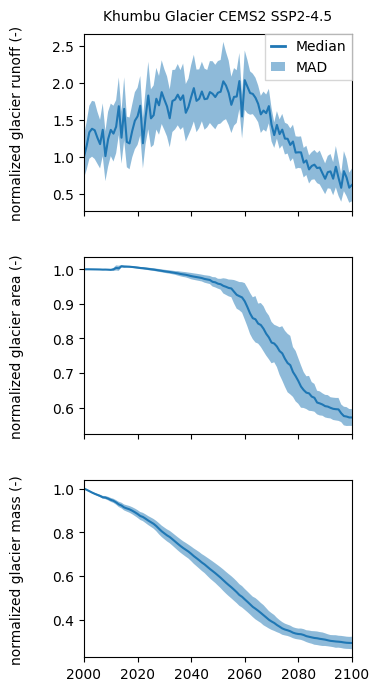

In [17]:
# create 3 x 1 plot with runoff, area, mass
import matplotlib.pyplot as plt
# initialize figure
fig,ax = plt.subplots(3,figsize=(4,7),sharex=True)
ax[0].plot(year,runoff[0]/runoff[0][0], label='Median')
ax[0].fill_between(year,
                    (runoff[0] - runoff[1]) / runoff[0][0],
                    (runoff[0] + runoff[1]) / runoff[0][0],
                    alpha=.5,
                    label='MAD')

ax[1].plot(year,area[0]/area[0][0])
ax[1].fill_between(year,
                    (area[0] - area[1]) / area[0][0],
                    (area[0] + area[1]) / area[0][0],
                    alpha=.5)

ax[2].plot(year,mass[0]/mass[0][0])
ax[2].fill_between(year,
                    (mass[0] - mass[1]) / mass[0][0],
                    (mass[0] + mass[1]) / mass[0][0],
                    alpha=.5)

# create legend
leg = ax[0].legend(fancybox=False,borderaxespad=0,handlelength=1,loc='upper right')
# increase linewidths in legend

for line in leg.get_lines():
    line.set_linewidth(2)
    
# set x axis limits to temporal extent of our data
ax[0].set_xlim([2000,2100])
# create x and y axis labels
ax[0].text(-0.25, 0.5, 'normalized glacier runoff (-)', va='center', ha='center', rotation=90, transform=ax[0].transAxes)
ax[1].text(-0.25, 0.5, 'normalized glacier area (-)', va='center', ha='center', rotation=90, transform=ax[1].transAxes)
ax[2].text(-0.25, 0.5, 'normalized glacier mass (-)', va='center', ha='center', rotation=90, transform=ax[2].transAxes)
# title
ax[0].text(.5, 1.1, 'Khumbu Glacier CEMS2 SSP2-4.5', va='center', ha='center', rotation=0, transform=ax[0].transAxes)
fig.tight_layout()

## Next:
Expand on what your learned in the PyGEM test notebooks (try your favorite glacier, or run for an entire region), or explore some of the other demonstration notebooks:
* [*run_calibration.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_calibration.ipynb): demonstrates regional model calibration at the end of the notebook
* [*run_simulation.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_simulation.ipynb): demonstrates regional model simulation at the end of the notebook
* [*analyze_regional_change.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/analyze_regional_change.ipynb): demonstrates regional model simulation analysis